In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import datetime
from pandas.api.types import CategoricalDtype
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve)

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.core.pylabtools import figsize
from IPython.display import display_html
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


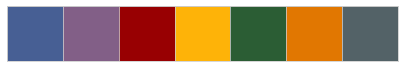

In [4]:
# import custom palette
from custom_modules import my_palette as mp

> **PART 1: EXPLORATORY DATA ANALYSIS**

In [5]:
# read in first dataset
logins_df = pd.read_json('logins.json')

In [6]:
# observe dimensionality of dataset
logins_df.shape

(93142, 1)

This dataset has many observations of one feature.

In [7]:
# observe feature name, data type, and possible null values
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


We have a bunch of Datetime objects.

In [8]:
# observe timestamp range
logins_df['login_time'].describe()

count                   93142
unique                  92265
top       1970-02-12 11:16:53
freq                        3
first     1970-01-01 20:12:16
last      1970-04-13 18:57:38
Name: login_time, dtype: object

The data covers about three and a half months.

In [9]:
# observe some data
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Aside from the obvious impossibility of logins occurring in the early 1970s, the data appears to be clean.

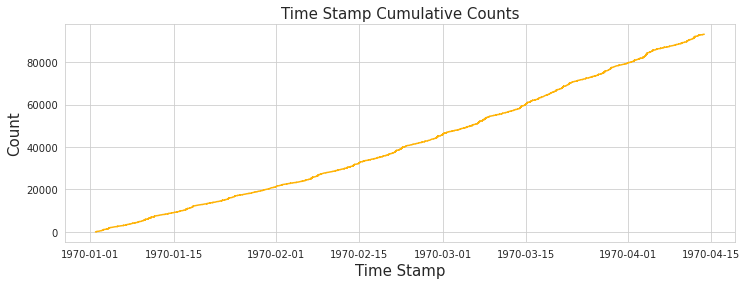

In [10]:
# plot timestamp cumulative distribution

sns.lineplot(
    x=logins_df['login_time'], 
    y=np.linspace(0, len(logins_df['login_time']), 
                  num=len(logins_df['login_time'])), color=mp.colors(3))

plt.xlabel('Time Stamp', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Time Stamp Cumulative Counts', fontsize=15);

The frequency of timestamps appears constant throughout the entire window.<br>
There is no indication of seasonality.

In [11]:
# round timestamps to 15 minute intervals
logins_df['login_time'] = logins_df['login_time'].dt.round('15min') 
logins_df.head()

,login_time
0,1970-01-01 20:15:00
1,1970-01-01 20:15:00
2,1970-01-01 20:15:00
3,1970-01-01 20:15:00
4,1970-01-01 20:30:00


In [12]:
# create day of the week feature
logins_df['day'] = logins_df['login_time'].apply(pd.Timestamp.day_name)
logins_df.head()

,login_time,day
0,1970-01-01 20:15:00,Thursday
1,1970-01-01 20:15:00,Thursday
2,1970-01-01 20:15:00,Thursday
3,1970-01-01 20:15:00,Thursday
4,1970-01-01 20:30:00,Thursday


In [13]:
# count timestamps grouped by day of the week
days_df = logins_df.groupby(['day'], as_index=False).count()
days_df

,day,login_time
0,Friday,15172
1,Monday,8836
2,Saturday,19415
3,Sunday,18204
4,Thursday,11963
5,Tuesday,9251
6,Wednesday,10301


In [14]:
# create ordered categories list for sorting days of the week
days_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=days_lst, ordered=True)

In [15]:
# convert day of the week values to ordered categories
days_df['day'] = days_df['day'].astype(cat_type)

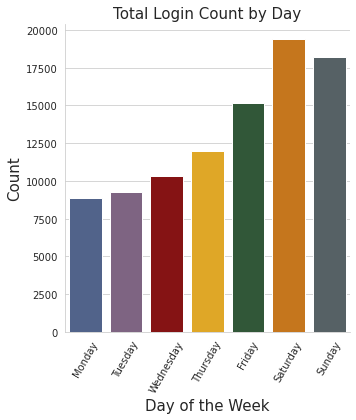

In [16]:
# plot login counts by day

sns.catplot(x='day', y='login_time', data=days_df, kind='bar')

plt.xticks(rotation=60)

plt.xlabel('Day of the Week', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Total Login Count by Day', fontsize=15);

User logins steadily increase throughout the week, peaking on Saturday.

In [17]:
# get day of week DataFrame
dow_df = logins_df.set_index(
    [logins_df.groupby(
        'day')['day'].cumcount(), 'day'])['login_time'].unstack().rename_axis(columns=None)
dow_df.head(3)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1970-01-02,1970-01-05,1970-01-03,1970-01-04,1970-01-01 20:15:00,1970-01-06,1970-01-07
1,1970-01-02,1970-01-05,1970-01-03,1970-01-04,1970-01-01 20:15:00,1970-01-06,1970-01-07
2,1970-01-02,1970-01-05,1970-01-03,1970-01-04,1970-01-01 20:15:00,1970-01-06,1970-01-07


In [18]:
# get time of day DataFrame
tod_df = pd.DataFrame([dow_df[a].dt.time for a in dow_df], dow_df.columns).transpose()
tod_df

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,00:00:00,00:00:00,00:00:00,00:00:00,20:15:00,00:00:00,00:00:00
1,00:00:00,00:00:00,00:00:00,00:00:00,20:15:00,00:00:00,00:00:00
2,00:00:00,00:00:00,00:00:00,00:00:00,20:15:00,00:00:00,00:00:00
3,00:00:00,00:15:00,00:00:00,00:00:00,20:15:00,00:15:00,00:00:00
4,00:00:00,00:00:00,00:00:00,00:00:00,20:30:00,00:15:00,00:00:00
...,...,...,...,...,...,...,...
19410,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT
19411,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT
19412,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT
19413,NaT,NaT,23:45:00,NaT,NaT,NaT,NaT


In [19]:
# observe frequencies and most common times of day
tod_df.describe()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,15172,8836,19415,18204,11963,9251,10301
unique,96,96,96,96,96,96,96
top,22:30:00,11:30:00,04:45:00,04:45:00,23:15:00,11:45:00,11:45:00
freq,419,252,513,601,286,273,308


In [20]:
# get counts for time of day by days of week
tod_counts_df = tod_df.apply(lambda x: x.value_counts()).reindex(columns=days_lst)
tod_counts_df.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
00:00:00,158,138,173,232,234,304,258
00:15:00,111,163,157,218,253,319,261
00:30:00,144,148,185,199,250,310,267
00:45:00,139,152,155,187,245,311,314
01:00:00,109,141,205,216,231,334,273


In [21]:
def plot_hours_of_day(data):
    """Plots hourly distribution of logins by day of the week"""
    plt.subplots(1, figsize=(16, 10))
    # set color palate cycle
    day_color = 0
    for day in data.columns:
        sns.lineplot(x=np.linspace(0, len(data[day]), num=len(data[day])), 
                     y=data[day], 
                     label=day, color=mp.colors(day_color))
        # get next color
        day_color += 1
    # make fancy time tick labels
    xtick_vals = np.arange(0, len(data.index) + 1, 4)
    xtick_names = np.asarray([datetime.time(i).strftime('%I %p') for i in range(24)])
    plt.xticks(xtick_vals, xtick_names, rotation=60)
    
    plt.xlabel('Time of Day', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    
    # spruce up legend
    leg = plt.legend(ncol=3, fontsize='x-large', markerscale=10)
    for legend in range(len(data.columns)):
        leg.get_lines()[legend].set_linewidth(6)
        
    plt.title('Days of Week Frequencies by Time of Day', fontsize=20);

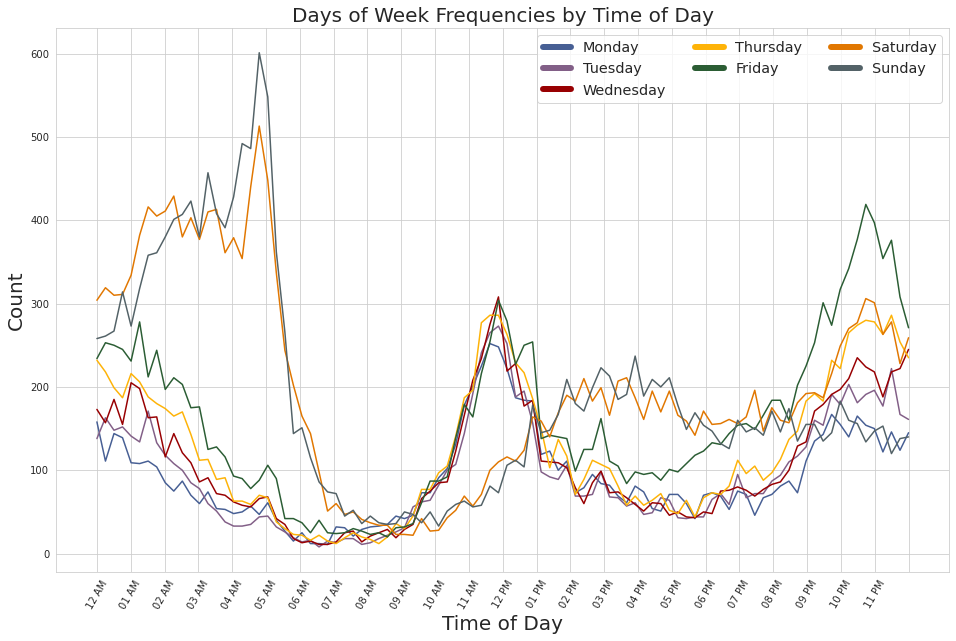

In [22]:
# plot login time of day by occurances for each day of week
plot_hours_of_day(tod_counts_df)

The days of the week show clear distinctions with respect to the variables plotted.

* Midnight-7AM:
    - weekday logins steadily decline (work week)
    - relative frequencies of usage during the weekdays increase as the week progresses
    - weekend calls rise until 5AM, then fall sharply (nightlife)
* 7AM-9AM:<br>
    - lowest time of usage for all days
    - weekend logins are a bit higher than they are for weekdays (walk of shame)
* 9AM-Noon:
    - calls increase for all days
    - weekday usage increases more sharply than weekend usage (9-5ers)
* Noon-5PM:<br>
    - weekday logins decline steadily
    - weekend usage increases until 2PM, then holds steady (brunch)
* 5PM-8PM:<br>
    - calls on all days hold steady, except Friday, which rise (TGIF)
    - Friday-Sunday usage is greater than for other days
* 8PM-10PM:<br>
    - logins on all days increase
* 10PM-Midnight:<br>
    - overall, usage declines for every day
    - Wednesday-Sunday logins increase until just before 11PM, then start to decline
    - Friday calls are the most frequent (weekend warrior)
    - Thursday and Sunday logins are the next strongest (Friday eve)

> **PART 2: EXPERIMENT & METRICS DESIGN**

First, I would want to know the business motivation behind the desire for drivers to serve both cities.<br>
Let's assume the answer is to increase profit, which dovetails with an increased number of daily rides.<br>
Due to the activity patterns of the two cities, the company would be able to serve both without hiring additional drivers.<br>
Establishing these goals from the outset will help me to generate an appropriate business question that can be tested.

Next, I would verify that the company has the necessary data to analyze the effects of the proposed changes.<br>
I would need the pretest average profit per ride, over all drivers, and the pretest number of rides for each driver.<br>
The number of rides would need to be separable by whether or not a bridge crossing was performed.

This would allow me to calculate the pretest profits generated by each driver.<br>
With this data, I could compute the average difference of profit posttest vs. pretest generated by each driver.<br>
This distribution can be used to give statistical significance to the effect of the experiment.

$$\delta Profit\;=\;ProfitPosttest\;-\;ProfitPretest$$
$$= AveProfit\;/\; Ride\;*\;[\delta RidesNoBridge + \delta RidesYesBridge]\;-\;RidesYesBridgePosttest\;*\;TollCost$$

I would choose mean difference in profit for each driver as the key metric to measure the success of this experiment.<br>
This is the goal of the experiment, as defined by the company.

* Define Question
    - Will the added cost of reimbursed bridge tolls result in increased average driver profit?
* Identify Variables
    - Independent Variables
        - Change in Number of Rides Where Driver Used the Bridge
        - Change in Number of Rides Where Driver Did Not Use the Bridge
        - Number of Rides Where Driver Used the Bridge (posttest)
        - Average Profit per ride for Each Driver  (pretest)
        - Bridge Toll Cost Per Ride (pretest: zero, posttest: constant)
    - Dependent Variable
        - Change in Profit for Each Driver
* Generate Hypothesis (paired-samples t test)
    - H0: The mean difference in driver profit will not be statistically different from zero.
    - HA: Reimbursing toll costs will have a statistically significant effect on average driver profit.
* Determine Experimental Design
    - There will be only one factor that the experiment will vary, the reimbursed cost of the bridge toll.
    - The experiment has a within-participants design, where all drivers will be reimbursed.
* Develop Experimental Procedure
    - The experiment will use GPS location and toll receipts to track which drivers crossed the bridge during their rides.
    - I will perform a two-sample bootstrap hypothesis test for the difference of the mean profit of the drivers.
    - Whether or not the null hypothesis is accepted will be determined by a confidence interval of no less than 95%.
* Analyze Results and Recommendation
    - After analysis, let's assume there is a real positive effect.
    - I would recommend that the company implement this change to the business model.
    - It would be an effective way to utilize current resources to generate additional profit.
* Next Steps
    - Other factors could be analyzed to provide deeper insight toward improving the results of future testing.
    - The drivers can be divided by the city they originally preferred to see if one used the bridge more than the other.
    - These effects should be monitored over a period of at least a year to observe seasonal variation.

> **PART 3: PREDICTIVE MODELING**

In [23]:
# read in second dataset
df = pd.read_json('ultimate_data_challenge.json')

In [24]:
# observe dimensionality of dataset
df.shape

(50000, 12)

In [25]:
# observe feature names, data types, and possible null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [26]:
# observe feature ranges
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


There's one user who took 125 trips in the first 30 days, over 4 times a day.<br>
This is most likely a data error.

In [27]:
# observe any extreme values
df['trips_in_first_30_days'].sort_values(ascending=False)[:5]

18514    125
99        73
3030      71
29070     63
48804     58
Name: trips_in_first_30_days, dtype: int64

The other high values seem plausible.<br>
I will remove that observation.

In [28]:
# drop outlier
df.drop(
    df[df['trips_in_first_30_days'] == df['trips_in_first_30_days'].max()].index, 
    inplace=True)
df['trips_in_first_30_days'].max()

73

In [29]:
# observe other extreme values
df['avg_dist'].sort_values(ascending=False)[:5]

20701    160.96
534      129.89
1302      79.69
22290     79.34
47595     77.13
Name: avg_dist, dtype: float64

Although there are two observations that are extreme, it is likely that these data points are reliable.

In [30]:
# observe some data
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [31]:
# get counts for categorical variables
print(df['city'].value_counts(), df['phone'].value_counts(), sep='\n\n')

Winterfell        23336
Astapor           16534
King's Landing    10129
Name: city, dtype: int64

iPhone     34581
Android    15022
Name: phone, dtype: int64


In [32]:
# check data types
print(type(df['signup_date'][0]), type(df['last_trip_date'][0]), sep='\n\n')

<class 'str'>

<class 'str'>


In [33]:
# convert time strings to useful  objects
df['signup_date'] = df['signup_date'].apply(pd.Timestamp)
df['last_trip_date'] = df['last_trip_date'].apply(pd.Timestamp)

In [34]:
# trust but verify
print(type(df['signup_date'][0]), type(df['last_trip_date'][0]), sep='\n\n')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [35]:
# observe feature ranges
df['signup_date'].describe()

count                   49999
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [36]:
# observe feature ranges
df['last_trip_date'].describe()

count                   49999
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [37]:
# observe one user
df.loc[0]

city                           King's Landing
trips_in_first_30_days                      4
signup_date               2014-01-25 00:00:00
avg_rating_of_driver                      4.7
avg_surge                                 1.1
last_trip_date            2014-06-17 00:00:00
phone                                  iPhone
surge_pct                                15.4
ultimate_black_user                      True
weekday_pct                              46.2
avg_dist                                 3.67
avg_rating_by_driver                        5
Name: 0, dtype: object

In [38]:
# check time data integrity
np.sum(df['last_trip_date'] - df['signup_date'] < pd.Timedelta('0 days'))

0

In [39]:
# get hypothetical current date
today = df['last_trip_date'].max()
today

Timestamp('2014-07-01 00:00:00')

In [40]:
# get 30 day Timedelta
delta_30 = pd.Timedelta('30 days')
delta_30

Timedelta('30 days 00:00:00')

In [41]:
def set_retained_value(row, val):
    """Assigns retained value based on boolean time condition"""
    return val[row]

In [42]:
# set boolean value assignments
retained_dict = {True: 1, False: 0}

In [43]:
# create binary retained user feature
df['retained'] = (today - df['last_trip_date'] <= delta_30).apply(
    set_retained_value, args=(retained_dict, ))
df[['last_trip_date', 'retained']].head()

,last_trip_date,retained
0,2014-06-17,1
1,2014-05-05,0
2,2014-01-07,0
3,2014-06-29,1
4,2014-03-15,0


In [44]:
# get retention rate for January signups
print('The retention rate is: {}%.'.format(np.round(df['retained'].mean() * 100)))

The retention rate is: 38.0%.


A little over a third of the people who signed up were retained.

In [45]:
def plot_correlations(data):
    """Return heatmap plot of correlations"""
    fig, ax = plt.subplots(figsize=(6.5,6.5))

    sns.set(font_scale=0.8)
    sns.heatmap(
        data.corr(), vmin=0, vmax=1.0, center=0, fmt='0.2f', square=True, 
        linewidths=0.5, annot=True, cbar_kws={"shrink": 0.60});

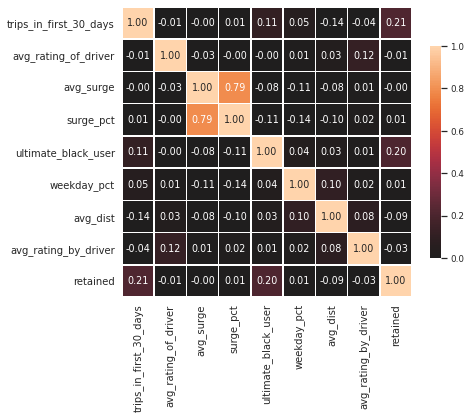

In [46]:
# plot correlations in dataset
plot_correlations(df)

The obligatory correlation plot offers little insight.

In [47]:
def plot_categoricals(data):
    """Plots target variable grouped by each categorical feature"""
    # establish figure height
    num_subplots = len(data.columns) - 1
    fig_height = num_subplots * 4
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot features in dataset
    count = 1
    for col in data.drop('retained', axis=1):
        plt.subplot(num_subplots, 1, count)
        plt.ylim(0, 0.7)
        # gather retained data by feature
        feature_df = data.groupby(col)['retained'].mean().reset_index()
        # mix up the color palette
        palette = [mp.colors(count - 1), mp.colors(count + 3), mp.colors(count + 2)]
        # plot feature values vs. retention rate
        sns.barplot(x=col, y='retained', data=feature_df, palette=palette)
        # get count of unique values in category
        num_cats = len(data[col].dropna().unique())
        # plot average retention rates
        plt.hlines(df['retained'].mean(), xmin=-0.5, xmax=num_cats - 0.5, 
                   linestyles=(0, (3, 1, 1, 1)), 
                   label='Average Overall Retention Rate', colors='k')
        plt.hlines(feature_df['retained'].mean(), xmin=-0.5, xmax=num_cats - 0.5, 
                   linestyles=(0, (3, 1, 1, 1, 1, 1)), 
                   label='Average Categorical Retention Rate', colors='r')
        count += 1
        plt.xlabel(col, fontsize=15)
        plt.ylabel('Retention Rate', fontsize=15)
        plt.legend(loc=2, fontsize='large')
    plt.suptitle("Retention Rate for Catergorical Variables", y=1.04, fontsize=20)
    plt.tight_layout();

In [48]:
# pick out categorical variables
cat_cols_lst = [feature for feature in df.columns if (
    type(df[feature][0]) is str) | (
    type(df[feature][0]) is np.bool_)]
cat_cols_lst

['city', 'phone', 'ultimate_black_user']

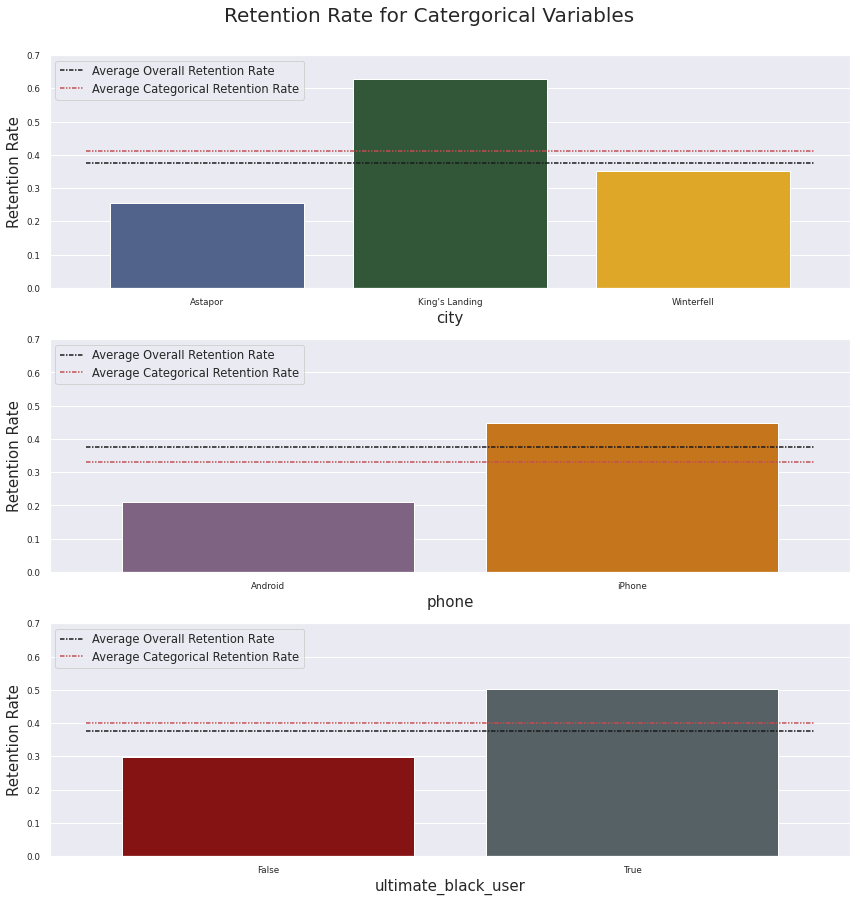

In [49]:
# plot categorical variables vs target
plot_categoricals(df[cat_cols_lst + ['retained']])

King's Landing inhabitants, iPhone users, and Ultimate Black Users have the highest retention rates in their categories.

I will use XGBoost to perform a binary classification for retained users.<br>
Tree boosting is well known to give accurate predictions on a wide range of machine learning problems.<br>
XGBoost is one of the fastest performing models and scaling is not required.<br>
Slower methods such as logistic regression or K-Nearest Neighbors could be used, as well.

One concern is that trees sometimes perform poorly on the sparse data I'll create with the Pandas get dummies method.

In [50]:
# separate data into features and target
X = df.drop('retained', axis=1)
y = df['retained']

In [51]:
# check data type before encoding
type(X['ultimate_black_user'][0])

numpy.bool_

In [52]:
# convert data type
X['ultimate_black_user'] = X['ultimate_black_user'].astype(str)
type(X['ultimate_black_user'][0])

str

In [53]:
# encode categorical variables
X = pd.get_dummies(X, prefix=cat_cols_lst).rename(str.lower, axis=1)
X.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_astapor,city_king's landing,city_winterfell,phone_android,phone_iphone,ultimate_black_user_false,ultimate_black_user_true
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


Concerning the Timestamp columns, I'm going to drop them.<br>
The signup date is a fairly random number between 1 and 31.<br>
There may be some prediction value gained by convering it to days of the week, but I'm deciding to proceed without it.<br>
The last trip date has already been used to determine the retained status.<br>
Keeping this feature may open the model up to a data leak and cause overfitting.

In [54]:
# drop Timestamp objects
X.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_astapor,city_king's landing,city_winterfell,phone_android,phone_iphone,ultimate_black_user_false,ultimate_black_user_true
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


In [55]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

In [56]:
def get_base_model(features, target):
    """Return base XGBoost classifier model"""
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=27, n_jobs=-1)
    model.fit(features, target)
    
    return model

In [57]:
def get_params(model):
    """Return hyperparameters of interest from classifier"""
    series = pd.Series(
        model.get_params(), name='model_params').drop(
        ['base_score', 'booster', 'missing', 'n_jobs', 'nthread', 'objective', 
         'random_state', 'scale_pos_weight', 'seed', 'silent', 'verbosity'])
    
    return series

In [58]:
# instantiate base model for given target and get parameters
base_model = get_base_model(X_train, y_train)
get_params(base_model)

colsample_bylevel      1
colsample_bynode       1
colsample_bytree       1
gamma                  0
learning_rate        0.1
max_delta_step         0
max_depth              3
min_child_weight       1
n_estimators         100
reg_alpha              0
reg_lambda             1
subsample              1
Name: model_params, dtype: object

In [59]:
def get_cv_adj_r2(features, target, model):
    """Return cross-validation average adjusted R2 score and adjusted R2 score range"""
    cv_results = cross_val_score(model, features, target, cv=10, n_jobs=-1)
    
    n = features.shape[0]
    p = features.shape[1]
    adj_r2 = 1 - (1 - cv_results) * ((n - 1)  / (n - p - 1))

    # get range of scores
    results_range = (np.min(adj_r2), np.max(adj_r2))
    # get average score and round to 5 decimal places
    ave_result = np.mean(adj_r2)

    return f'Average Adjusted R2 Score: {ave_result:.4f}, Range: ({results_range[0]:.4f}, {results_range[1]:.4f})'

In [60]:
# get statistics for 10 fold cross-validation
get_cv_adj_r2(X_train, y_train, base_model)

'Average Adjusted R2 Score: 0.7863, Range: (0.7759, 0.7982)'

The base model is a fairly strong predictor with a narrow range of cross-validation scores.

In [61]:
def plot_predictions(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    guesses = []
    for guess, truth in zip(model.predict(X_test), y_test):
        if guess == truth:
            guesses.append('Good Guess')
        else:
            guesses.append('Bad Guess')
    sns.countplot(guesses)

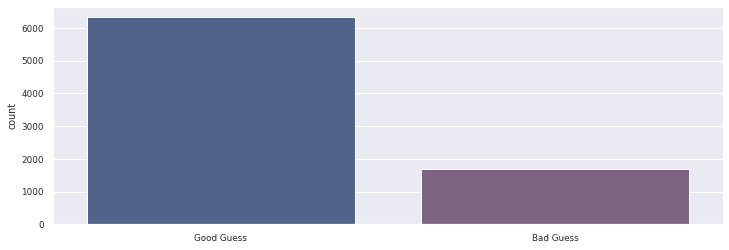

In [62]:
# plot prediction for out of the box binary classifier model
plot_predictions(X_train, y_train, base_model)

We have a fairly good guessing machine.

In [63]:
def get_reports(features, target, model):
    """Return classification reports and confusion matrices for traning and test data"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)    
    # get classification reports
    cr_train_df = pd.DataFrame(
        classification_report(
            y_train, model.predict(X_train), digits=3, output_dict=True)).transpose()
    cr_test_df = pd.DataFrame(
        classification_report(
            y_test, model.predict(X_test), digits=3, output_dict=True)).transpose()
    # get confusion matrices
    cm_train_df = pd.DataFrame(
        confusion_matrix(y_train, model.predict(X_train)))
    cm_test_df = pd.DataFrame(
        confusion_matrix(y_test, model.predict(X_test)))
    # prep data for HTML display
    df1_styler = cr_train_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Training Classification Report')
    df2_styler = cr_test_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Test Classification Report')
    df3_styler = cm_train_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Training Confusion Matrix')
    df4_styler = cm_test_df.style.set_table_attributes(
        "style='display:inline'").set_caption(
        'Test Confusion Matrix')
    # display reports and matrices
    display_html(
        df1_styler._repr_html_() 
        + df2_styler._repr_html_() 
        + df3_styler._repr_html_() 
        + df4_styler._repr_html_(), raw=True)    

In [64]:
# observe classification metrics
get_reports(X_train, y_train, base_model)

,precision,recall,f1-score,support
0,0.811685,0.860886,0.835562,19962.000000
1,0.743512,0.668771,0.704164,12037.000000
accuracy,0.788618,0.788618,0.788618,0.788618
macro avg,0.777598,0.764828,0.769863,31999.000000
weighted avg,0.786040,0.788618,0.786134,31999.000000
,precision,recall,f1-score,support
0,0.813049,0.865300,0.838361,5026.000000
1,0.744625,0.663753,0.701867,2974.000000
accuracy,0.790375,0.790375,0.790375,0.790375
macro avg,0.778837,0.764526,0.770114,8000.000000


The model is better at predicting users who will churn than it is at predicting users who will stay.<br>
It only correctly labeled 2/3 of the users who actually stayed.<br>
It correctly labeled 86% of the users who churned.

In [65]:
def plot_roc_curve(features, target, model):
    """Return ROC curve"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27) 
    # get ROC data for training data
    fpr_train, tpr_train = roc_curve(y_train, model.predict(X_train))[:2]
    roc_score_train = roc_auc_score(y_train, model.predict(X_train))
    # get ROC data for test data
    fpr_test, tpr_test = roc_curve(y_test, model.predict(X_test))[:2]
    roc_score_test = roc_auc_score(y_test, model.predict(X_test))
    
    ax = sns.lineplot(fpr_train, tpr_train, color=mp.colors(4), label='Training Model')
    ax = sns.lineplot(fpr_test, tpr_test, color=mp.colors(5), label='Test Model')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.title('ROC Curves');
    return f'Training ROC AUC Score: {roc_score_train:.4f}, Test ROC AUC Score: {roc_score_test:.4f}'

'Training ROC AUC Score: 0.7648, Test ROC AUC Score: 0.7645'

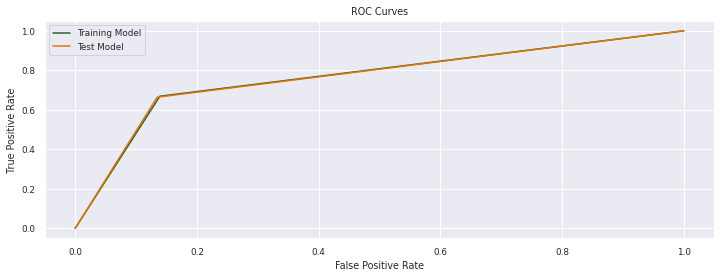

In [66]:
# observe ROC AUC scores and ROC curves for both training and test data
plot_roc_curve(X_train, y_train, base_model)

The model performs the same on the test data as it does on the training data.<br>
This indicates that the model is generalizable to new data.

In [67]:
def plot_feature_importance(model):
    """Plots the features by importance to model prediction"""
    sns.set_style('dark')
    
    ax = xgb.plot_importance(base_model)
    
    ax.figure.set_size_inches(12, 8)
    
    plt.xlabel('F-score', fontsize=15)
    plt.ylabel('Features', fontsize=18)
    plt.title('Feature Importance', fontsize=20);

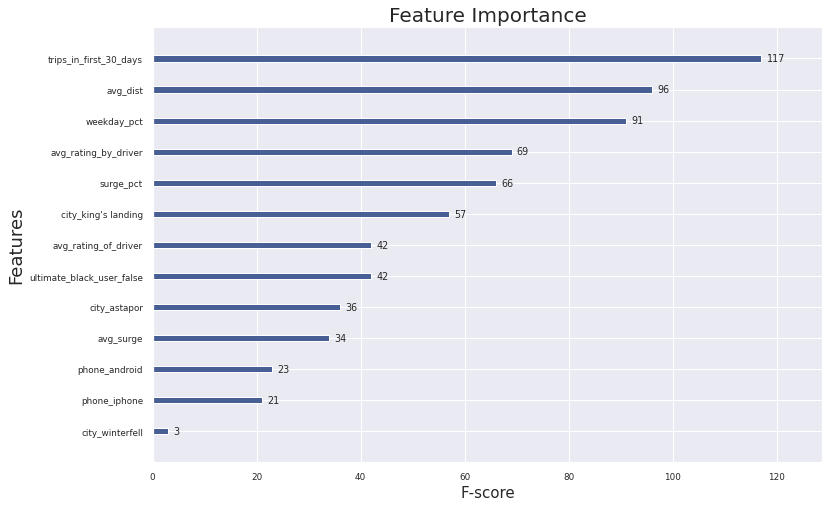

In [68]:
# observe feature importance
plot_feature_importance(base_model)

The most important features in predicting user retention were trips in 1st 30 days, average distance, and weekday percent.

I'll observe the plot of the most dominant feature for the predictions.

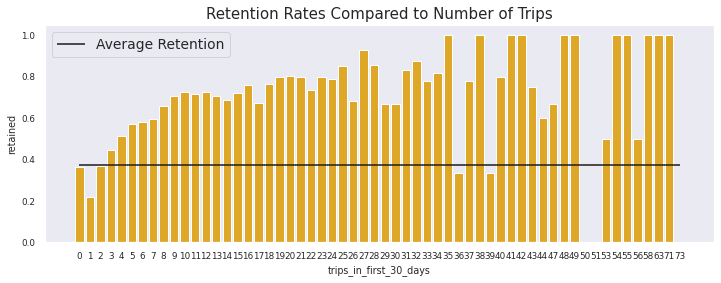

In [69]:
# plot trips taken in the first 30 days after signup vs. retention rate
sns.barplot(x='trips_in_first_30_days', y='retained', 
            data=df.groupby('trips_in_first_30_days')['retained'].mean().reset_index(), 
            color=mp.colors(3))
plt.hlines(df['retained'].mean(), 0, 57, label='Average Retention')

plt.legend(fontsize='x-large')
plt.title('Retention Rates Compared to Number of Trips', fontsize=15);

In general, once a user exceeded 2 trips in the first month, their retention rate was above average.<br>
The data may imply that familiarity is a factor in user retention.<br>
This may be leveraged by offering a discount on the first 3 trips after signup to ensure users exceed this threshold.